In [1]:
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

device = "cuda:0" if torch.cuda.is_available() else "cpu"
plt.style.use("dark_paper")

In [2]:
imagenet_data = torchvision.datasets.MNIST("./data/")
# transform = torchvision.transforms.RandomAffine(0,translate=(0.1,0.1))

In [3]:
# Pick some example digits and put them in a 10 by 10 grid (280x280) images
nums  = list()
for num in range(10):
    loc = torch.where(imagenet_data.targets==num)[0][0]
    for i in range(10):
        istart = i * 28
        iend = (i+1) * 28
        for j in range(10):
            jstart = i * 28
            jend = (i+1) * 28
            zeros = torch.zeros(280, 280)
            zeros[istart:iend, jstart:jend] = imagenet_data.data[loc]
            nums.append(zeros)
nums = torch.stack(nums)


trainset = torch.utils.data.TensorDataset(nums.unsqueeze(1),torch.arange(10).repeat_interleave(100))
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=10,
                                          shuffle=True)
nums  = list()
for num in range(10):
    loc = torch.where(imagenet_data.targets==num)[0][0]
    for i in range(10):
        istart = i * 28
        iend = (i+1) * 28
        for j in range(10):
            jstart = i * 28
            jend = (i+1) * 28
            zeros = torch.zeros(280, 280)
            zeros[istart:iend, jstart:jend] = imagenet_data.data[loc]
            nums.append(zeros)
nums = torch.stack(nums)
valset = torch.utils.data.TensorDataset(nums.unsqueeze(1),torch.arange(10).repeat_interleave(100))
valloader = torch.utils.data.DataLoader(valset,batch_size=10)

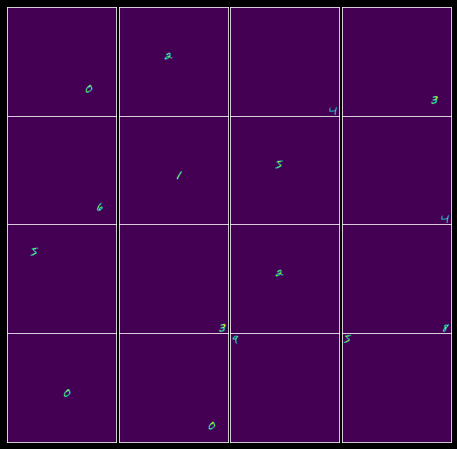

In [4]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))
for i,ax in zip(np.random.randint(0,nums.shape[0],size=16),axes.flatten()):
    ax.imshow(nums[i])
    ax.set_xticks([])
    ax.set_yticks([])
#fig.tight_layout(pad=0,h_pad=0,w_pad=0)
plt.subplots_adjust(hspace=0,wspace=0)

In [5]:
mlp = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(280*280,1024),
                          torch.nn.ReLU(),
                          torch.nn.Linear(1024,10))
mlp.to(device)
# cnn = torch.nn.Sequential(torch.nn.Conv2d(1,1024,kernel_size=28,stride=28),
#                           torch.nn.ReLU(),
#                           torch.nn.Flatten(),
#                           torch.nn.Linear((10)**2*1024,10))
# cnn.to(device)
criterion = torch.nn.CrossEntropyLoss()

#  CNN Training

In [16]:
def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
    ])[activation]
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=10, h = 280, w = 280, f = 1024, ks = 28, activation='relu', *args, **kwargs):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
                    nn.Conv2d(in_channels, f, kernel_size = ks, stride = 28, padding = 0),
                    nn.BatchNorm2d(f),
                    activation_func(activation)
        )
        self.decoder = nn.Linear(int(h*w/ks**2)*f, out_channels)

    def forward(self, x):
        x = self.conv_block1(x)
        x = x.view(x.size(0),-1)
        x = self.decoder(x)
        return x
cnn = CNN()
cnn.to(device)

CNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 1024, kernel_size=(28, 28), stride=(28, 28))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (decoder): Linear(in_features=102400, out_features=10, bias=True)
)

In [7]:
# Define training and validation functions
def train(model,x,y):
    x = x.to(device)
    y = y.to(device)
    model.train()
    yhat = model(x)
    loss = criterion(yhat,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
def validate(model,x,y):
    x = x.to(device)
    y = y.to(device)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat,y)
        return loss.item()

In [17]:
# Train the model for 100 epochs 
optimizer = torch.optim.Adam(cnn.parameters(),lr=1e-2)
T = 30
losses_train = []
losses_val = []
cnn.train()
total_steps = len(trainloader)
for t in range(1,T+1):
    loss = list() # Combine losses from differetn steps in a single epoch
    # Training Step
    for step,(x,y) in enumerate(trainloader):
        loss_ = train(cnn,x,y)
        loss.append(loss_)
        print(f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
    loss = np.mean(loss)
    losses_train.append(loss)
    # Validation Step
    if t%10 == 0:
        message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
        loss = []
        with torch.no_grad():
            for x,y in valloader:
                loss_ = validate(cnn,x,y)
                loss.append(loss_)
        loss = np.mean(loss)
        losses_val.append(loss)
        message += f"Validation loss: {loss:^.4f}"
        print(message) #,end="\r"

Epoch 010/30  | Training loss: 0.0000 - Validation loss: 0.0000
Epoch 020/30  | Training loss: 0.0000 - Validation loss: 0.0000
Epoch 030/30  | Training loss: 0.0000 - Validation loss: 0.0000


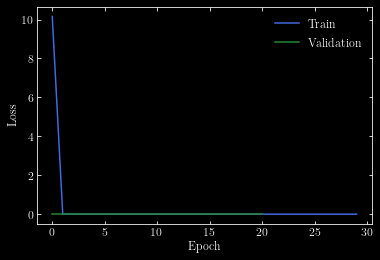

In [19]:
plt.plot(np.arange(0,T),losses_train[0:],label="Train")
plt.plot(np.arange(0,T,10),losses_val,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
with torch.no_grad():
    cnn.eval()
    x = trainset.tensors[0].to(device)
    y = trainset.tensors[1].numpy()
    yhat = cnn(x).cpu().numpy()
out = classification_report(y,yhat.argmax(axis=1))
print(out)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
           9       1.00      1.00      1.00       100

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



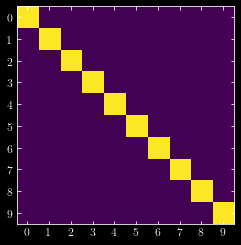

In [25]:
plt.imshow(confusion_matrix(y,yhat.argmax(axis=1)))
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()

# MLP Training

In [8]:
# Train the model for 100 epochs 
optimizer = torch.optim.Adam(mlp.parameters(),lr=1e-2)
T = 30
losses_train = []
losses_val = []
mlp.train()
total_steps = len(trainloader)
for t in range(1,T+1):
    loss = list() # Combine losses from differetn steps in a single epoch
    # Training Step
    for step,(x,y) in enumerate(trainloader):
        loss_ = train(mlp,x,y)
        loss.append(loss_)
        print(f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
    loss = np.mean(loss)
    losses_train.append(loss)
    # Validation Step
    if t%10 == 0:
        message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
        loss = []
        with torch.no_grad():
            for x,y in valloader:
                loss_ = validate(mlp,x,y)
                loss.append(loss_)
        loss = np.mean(loss)
        losses_val.append(loss)
        message += f"Validation loss: {loss:^.4f}"
        print(message) #,end="\r"

Epoch 010/30  | Training loss: 0.0000 - Validation loss: 0.0000
Epoch 020/30  | Training loss: 0.0000 - Validation loss: 0.0000
Epoch 030/30  | Training loss: 0.0000 - Validation loss: 0.0000


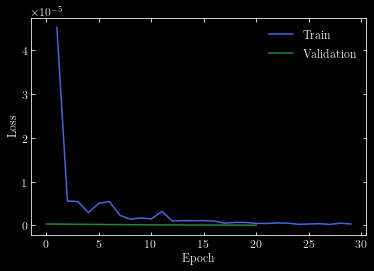

In [18]:
plt.plot(np.arange(1,T),losses_train[1:],label="Train")
plt.plot(np.arange(0,T,10),losses_val,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    mlp.eval()
    x = trainset.tensors[0].to(device)
    y = trainset.tensors[1].numpy()
    yhat = mlp(x).cpu().numpy()
out = classification_report(y,yhat.argmax(axis=1))
print(out)